## Fine-tuning of RoBERTa-base on AG News Dataset

### Pre-config and Dataset Loading

In [ ]:
import os
import math
import random
from dataclasses import dataclass, field
from typing import Optional, Dict, Any

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig,
)
import evaluate

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_LABELS = 4
MAX_LEN = 128              # shorter headlines → 128 is enough
TEACHER_NAME = "microsoft/deberta-v3-large"   # change if desired
STUDENT_NAME  = "roberta-base"

print("Loading AG News …")
raw_ds = load_dataset("ag_news", split="train")

# Simple 90 / 10 split for validation (un‑augmented)
split = raw_ds.train_test_split(test_size=10_000, seed=SEED)
train_raw, val_raw = split["train"], split["test"]

print(f"Train {len(train_raw)}  •  Val {len(val_raw)}")

### Load the augmented dataset (should first run offline_aug.py to obtain the augmented training set)

In [2]:
from datasets import load_dataset, load_from_disk, concatenate_datasets

augmented_dataset = load_from_disk("augmented_harsh_two_stage_train.arrow")
aug_split_dataset = augmented_dataset.train_test_split(test_size=10000, seed=42)
train_aug = aug_split_dataset['train']
train_ds = concatenate_datasets([train_raw, train_aug])
print(f"Train {len(train_ds)}  •  Val {len(val_raw)}")

Train 220000  •  Val 10000


### Tokenization

In [3]:
print("Tokenising …")
tokenizer = AutoTokenizer.from_pretrained(STUDENT_NAME, use_fast=True)
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels")
val_ds   = val_raw.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels")

collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

Tokenising …


### Fine-tuning Teacher's Model

In [4]:
print("\n📚  Fine‑tuning teacher …")
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_NAME,
    num_labels=NUM_LABELS,
).to(DEVICE)

teach_args = TrainingArguments(
    output_dir="teacher_ckpt",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=200,
    seed=SEED,
)

acc = evaluate.load("accuracy")

def acc_metric(p):
    logits, labels = p
    preds = logits.argmax(-1)
    return {"accuracy": acc.compute(predictions=preds, references=labels)["accuracy"]}

teacher_trainer = Trainer(
    model=teacher_model,
    args=teach_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    compute_metrics=acc_metric,
)


📚  Fine‑tuning teacher …


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
teacher_trainer.train()
teacher_trainer.save_model("teacher_ckpt/best")


📚  Fine‑tuning teacher …


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alkaidone (alkaidone-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.353000,0.292117,0.905500
2,0.269900,0.247591,0.926800


### Or if the model is already trained, load from the trained model.

In [5]:
# from transformers import AutoModelForSequenceClassification
# from torch import device
# DEVICE = device("cuda" if torch.cuda.is_available() else "cpu")
# # Define the path where the model was saved
# load_path = "teacher_ckpt/best"

# print(f"\n📚 Loading teacher model from {load_path} …")

# # Load the model from the saved directory
# loaded_teacher_model = AutoModelForSequenceClassification.from_pretrained(load_path)
# loaded_teacher_model.to(DEVICE)
# print("Teacher model loaded successfully.")


📚 Loading teacher model from teacher_ckpt/best …
Teacher model loaded successfully.


In [6]:
import torch
from torch.utils.data import DataLoader
# Assuming you have loaded the model into loaded_teacher_model variable
# from transformers import AutoModelForSequenceClassification
# load_path = "teacher_ckpt/best"
# loaded_teacher_model = AutoModelForSequenceClassification.from_pretrained(load_path)
# loaded_teacher_model.to(DEVICE) # Make sure it's on the correct device

# Assuming train_raw, tokenize, collator, DEVICE, and T are defined
# Example:
# from datasets import load_dataset
# from transformers import AutoTokenizer, DataCollatorWithPadding
# dataset_name = "imdb"
# train_raw = load_dataset(dataset_name, split="train")
# TOKENIZER_NAME = "bert-base-uncased" # Or whatever your teacher model used
# tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
# def tokenize(examples):
#     return tokenizer(examples["text"], truncation=True)
# collator = DataCollatorWithPadding(tokenizer=tokenizer)
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# T = 2.0 # Temperature

print("\n🔮  Generating soft labels with loaded teacher model …")
soft_labels = []

# Set the loaded model to evaluation mode
loaded_teacher_model.eval()

# Create the DataLoader for the *original* training data
# Ensure train_raw is tokenized and label column is renamed correctly
# This assumes train_raw is a Hugging Face Dataset
loader = DataLoader(
    train_raw.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels"),
    batch_size=64, # Or your desired batch size
    collate_fn=collator
)

T = 2.0 # Temperature (as defined in your original snippet)

# Use torch.no_grad() to prevent gradient calculation during inference
with torch.no_grad():
    for batch in loader:
        # Move batch data to the same device as the model
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # Get logits from the loaded model
        outputs = loaded_teacher_model(**batch)
        logits = outputs.logits

        # Apply temperature and calculate softmax probabilities (soft targets)
        soft = torch.softmax(logits / T, dim=-1).cpu()

        # Collect the soft targets
        soft_labels.append(soft)

# Concatenate all collected soft targets
soft_labels = torch.cat(soft_labels)

print("Soft label generation complete.")

# Attach soft labels to the original dataset as a new column
# Convert torch tensor to list of numpy arrays or a single numpy array
train_raw = train_raw.add_column("soft", soft_labels.numpy().tolist()) # or list(soft_labels.numpy())

# Tokenize the dataset again (or just keep the tokenized version from the loader setup)
# and potentially rename columns if needed for student training
# The original snippet re-tokenizes and renames, so let's follow that pattern
train_soft = train_raw.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels")

print("Soft labels added to dataset.")
# train_soft is now your training dataset ready for student training,
# containing 'input_ids', 'attention_mask', 'labels' (hard labels), and 'soft' (soft targets).


🔮  Generating soft labels with loaded teacher model …
Soft label generation complete.
Soft labels added to dataset.


### Add soft labels

In [ ]:
print("\n🔮  Generating soft labels …")
soft_labels = []
teacher_model.eval()
loader = DataLoader(train_raw.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels"),
                    batch_size=64, collate_fn=collator)
T = 2.0
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = teacher_model(**batch).logits / T
        soft = torch.softmax(logits, dim=-1).cpu()
        soft_labels.append(soft)
soft_labels = torch.cat(soft_labels)

# Attach to dataset as new column
train_raw = train_raw.add_column("soft", list(soft_labels.numpy()))
train_soft = train_raw.map(tokenize, batched=True, remove_columns=["text"]).rename_column("label", "labels")


🔮  Generating soft labels …


Map: 100%|████████████████████████████████████████████████████████████| 110000/110000 [00:03<00:00, 30038.95 examples/s]


In [7]:
print(train_soft.column_names)

from transformers import DataCollatorWithPadding
import torch

base_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

def kd_collator(features):
    batch = base_collator(features)                    # pads std fields
    if "soft" in features[0]:                          # ⬅ check first item
        batch["soft"] = torch.tensor(
            [f["soft"] for f in features], dtype=torch.float32
        )
    return batch

['labels', 'soft', 'input_ids', 'attention_mask']


### Distillation Trainer with R‑Drop & label smoothing

In [8]:
@dataclass
class KDConfig:
    alpha: float = 0.9          # KD loss weight
    temperature: float = 2.0
    rdrop_lambda: float = 0.5   # weight of KL(p1‖p2) for R‑Drop
    label_smoothing: float = 0.1

class DistillTrainer(Trainer):
    def __init__(self, kd_cfg: KDConfig, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kd_cfg = kd_cfg
        self.ce = nn.CrossEntropyLoss(label_smoothing=kd_cfg.label_smoothing)
        self.kl = nn.KLDivLoss(reduction="batchmean")

    def compute_loss(self, model, inputs, return_outputs=False, **_):
        soft = inputs.pop("soft", None)        # ← ① safe pop
        if soft is not None:                   # ← ② training phase
            soft = soft.to(model.device) 
        # ------------------------------------------------------------
        outputs1 = model(**inputs)
        outputs2 = model(**inputs)
        logits1, logits2 = outputs1.logits, outputs2.logits

        hard_loss = self.ce(logits1, inputs["labels"])

        if soft is None:                      # validation: KD & R‑Drop off
            total = hard_loss
        else:
            kd_loss = self.kl(
                nn.functional.log_softmax(logits1 / self.kd_cfg.temperature, dim=-1),
                soft
            ) * (self.kd_cfg.temperature ** 2)
            rdrop_loss = self.kl(
                nn.functional.log_softmax(logits1, dim=-1),
                nn.functional.softmax(logits2, dim=-1)
            ) + self.kl(
                nn.functional.log_softmax(logits2, dim=-1),
                nn.functional.softmax(logits1, dim=-1)
            )
            total = (
                self.kd_cfg.alpha * kd_loss +
                (1 - self.kd_cfg.alpha) * hard_loss +
                self.kd_cfg.rdrop_lambda * rdrop_loss
            )

        return (total, outputs1) if return_outputs else total

### Prepare STUDENT (RoBERTa-base + 4-bit + QLoRA)

In [9]:
print("\n  Preparing student with QLoRA …")

from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    llm_int8_skip_modules=["classifier"],
    bnb_4bit_skip_modules=["classifier"],   # new
)

student = AutoModelForSequenceClassification.from_pretrained(
    STUDENT_NAME,
    num_labels=NUM_LABELS,
    quantization_config=bnb_cfg,
    torch_dtype=torch.bfloat16,
)

# 1) Prepare 4-bit base model for LoRA
student = prepare_model_for_kbit_training(student)
target = ["q_proj", "k_proj", "v_proj", "out_proj"] 

# 3) Define LoRA config & wrap the model
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # sequence classification task
    inference_mode=False,
    r=8,            # low rank for adapters
    lora_alpha=16,   # scaling factor for LoRA
    lora_dropout=0.8,  # dropout on adapter outputs for regularization
    bias="lora_only"     # do not train any biases (only LoRA weights will be trainable)
)
student = get_peft_model(student, lora_config)

student.to(DEVICE)
student.print_trainable_parameters()


  Preparing student with QLoRA …


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 907,012 || all params: 125,537,288 || trainable%: 0.7225


### Train student with distillation

In [10]:
from bitsandbytes.optim import PagedAdamW8bit

print("\n🚀  Distilling student …")
kd_args = TrainingArguments(
    output_dir="student_kd",
    optim="adamw_torch_fused",
    num_train_epochs=1,
    remove_unused_columns=False,    # <‑‑ KEEP
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=1e-3,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=200,
    seed=SEED,
    bf16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},   # ← add
    dataloader_num_workers = 8,
    dataloader_pin_memory  = True,
)

trainer = DistillTrainer(
    kd_cfg=KDConfig(),
    model=student,
    args=kd_args,
    train_dataset=train_soft,
    eval_dataset=val_ds,
    data_collator=kd_collator,
    compute_metrics=acc_metric,
)
trainer.train()
trainer.save_model("student_kd/best")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



🚀  Distilling student …


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alkaidone (alkaidone-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.315800,0.733666,0.930300


### Print Eval Accuracies

In [15]:
import pandas as pd
from tqdm import tqdm
print("Best validation accuracy:", trainer.state.best_metric)

Best validation accuracy: 0.9303


### Evaluate on the unlabelled testset

In [16]:
def prepare_inference_model(peft_model, merge_lora=True):
    """
    • peft_model : PEFT-wrapped model returned by Trainer (student_kd)
    • merge_lora : merge LoRA weights into the 4‑bit base for faster inference
    """
    peft_model.eval()
    if merge_lora and hasattr(peft_model, "merge_and_unload"):
        peft_model = peft_model.merge_and_unload()
    peft_model.to("cuda" if torch.cuda.is_available() else "cpu")
    return peft_model

def run_eval_or_infer(
        model,
        dataset: Dataset,
        tokenizer,
        *,
        has_labels: bool = False,
        batch_size: int = 128,
):
    """
    Returns:
        • (metrics_dict, preds_tensor) if has_labels=True
        • preds_tensor                if has_labels=False
    """
    collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=collator,
        pin_memory=torch.cuda.is_available()
    )

    device = next(model.parameters()).device
    metric = evaluate.load("accuracy") if has_labels else None
    preds_all = []

    autocast = torch.cuda.amp.autocast if torch.cuda.is_available() else \
               torch.cpu.amp.autocast

    for batch in tqdm(loader, desc="Inference"):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad(), autocast(dtype=torch.bfloat16):
            logits = model(**batch).logits

        preds = logits.argmax(dim=-1)
        preds_all.append(preds.cpu())

        if has_labels:
            metric.add_batch(
                predictions=preds.numpy(),
                references=batch["labels"].cpu().numpy()
            )

    preds_all = torch.cat(preds_all)

    if has_labels:
        return metric.compute(), preds_all
    return preds_all


# ---------------------------------------------------------------------
# Example: un‑labelled test split
# ---------------------------------------------------------------------

unlabelled_df   = pd.read_pickle("test_unlabelled.pkl")
test_ds         = unlabelled_df
test_ds_tok     = test_ds.map(tokenize, batched=True,
                              remove_columns=["text"])

student_inf     = prepare_inference_model(trainer.model)

preds           = run_eval_or_infer(student_inf,
                                    test_ds_tok,
                                    tokenizer,
                                    has_labels=False,
                                    batch_size=128)

pd.Series(preds.numpy(), name="Label").to_csv("inference_output.csv",
                                              index_label="ID")
print("✔ Inference complete → inference_output.csv")

Inference:   0%|                                                                                 | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_410/1216725047.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=torch.bfloat16):
Inference: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.04it/s]

✔ Inference complete → inference_output.csv


# Load the results from Wandb

## Plot the training loss and eval accuracy

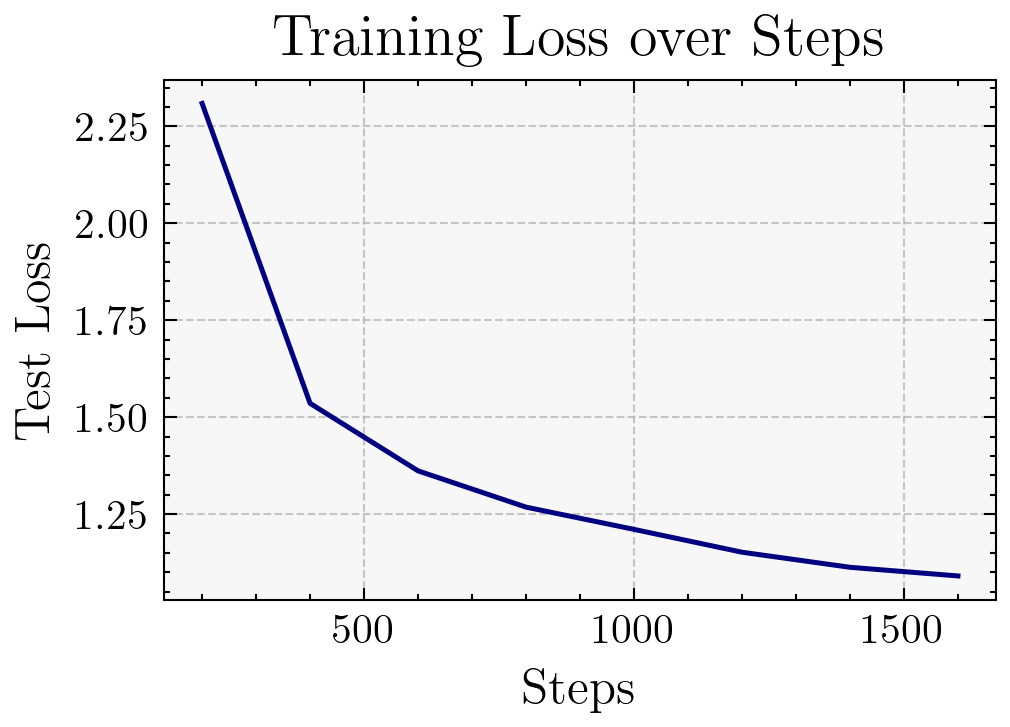

In [1]:
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import scienceplots  # Import scienceplots to register the styles
import pandas as pd

plt.style.use(['science', 'high-vis'])

# Enable LaTeX-style text rendering and Times New Roman font
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 300,                # Higher resolution
    "axes.facecolor": "#f7f7f7",      # Light grey facecolor for contrast
})

# Read the training loss CSV
csv_path = "wandb_export_2025-04-21T19_42_51.597-04_00.csv"
df = pd.read_csv(csv_path)

# Identify columns
step_col = next((c for c in df.columns if "global_step" in c.lower()), df.columns[0])
loss_col = next(
    (c for c in df.columns if "loss" in c.lower() and "min" not in c.lower() and "max" not in c.lower()),
    df.columns[1]
)

# Filter to first 1600 steps
df_filtered = df[df[step_col] <= 1600]

fig, ax = plt.subplots()  # higher resolution
ax.plot(df_filtered[step_col], df_filtered[loss_col], linewidth=1.2, color='navy')

ax.set_title("Training Loss over Steps", fontsize=14)
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Test Loss", fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
fig.savefig('train_loss_plot.pdf', format='pdf', bbox_inches='tight')


## Print the eval accuracy and loss

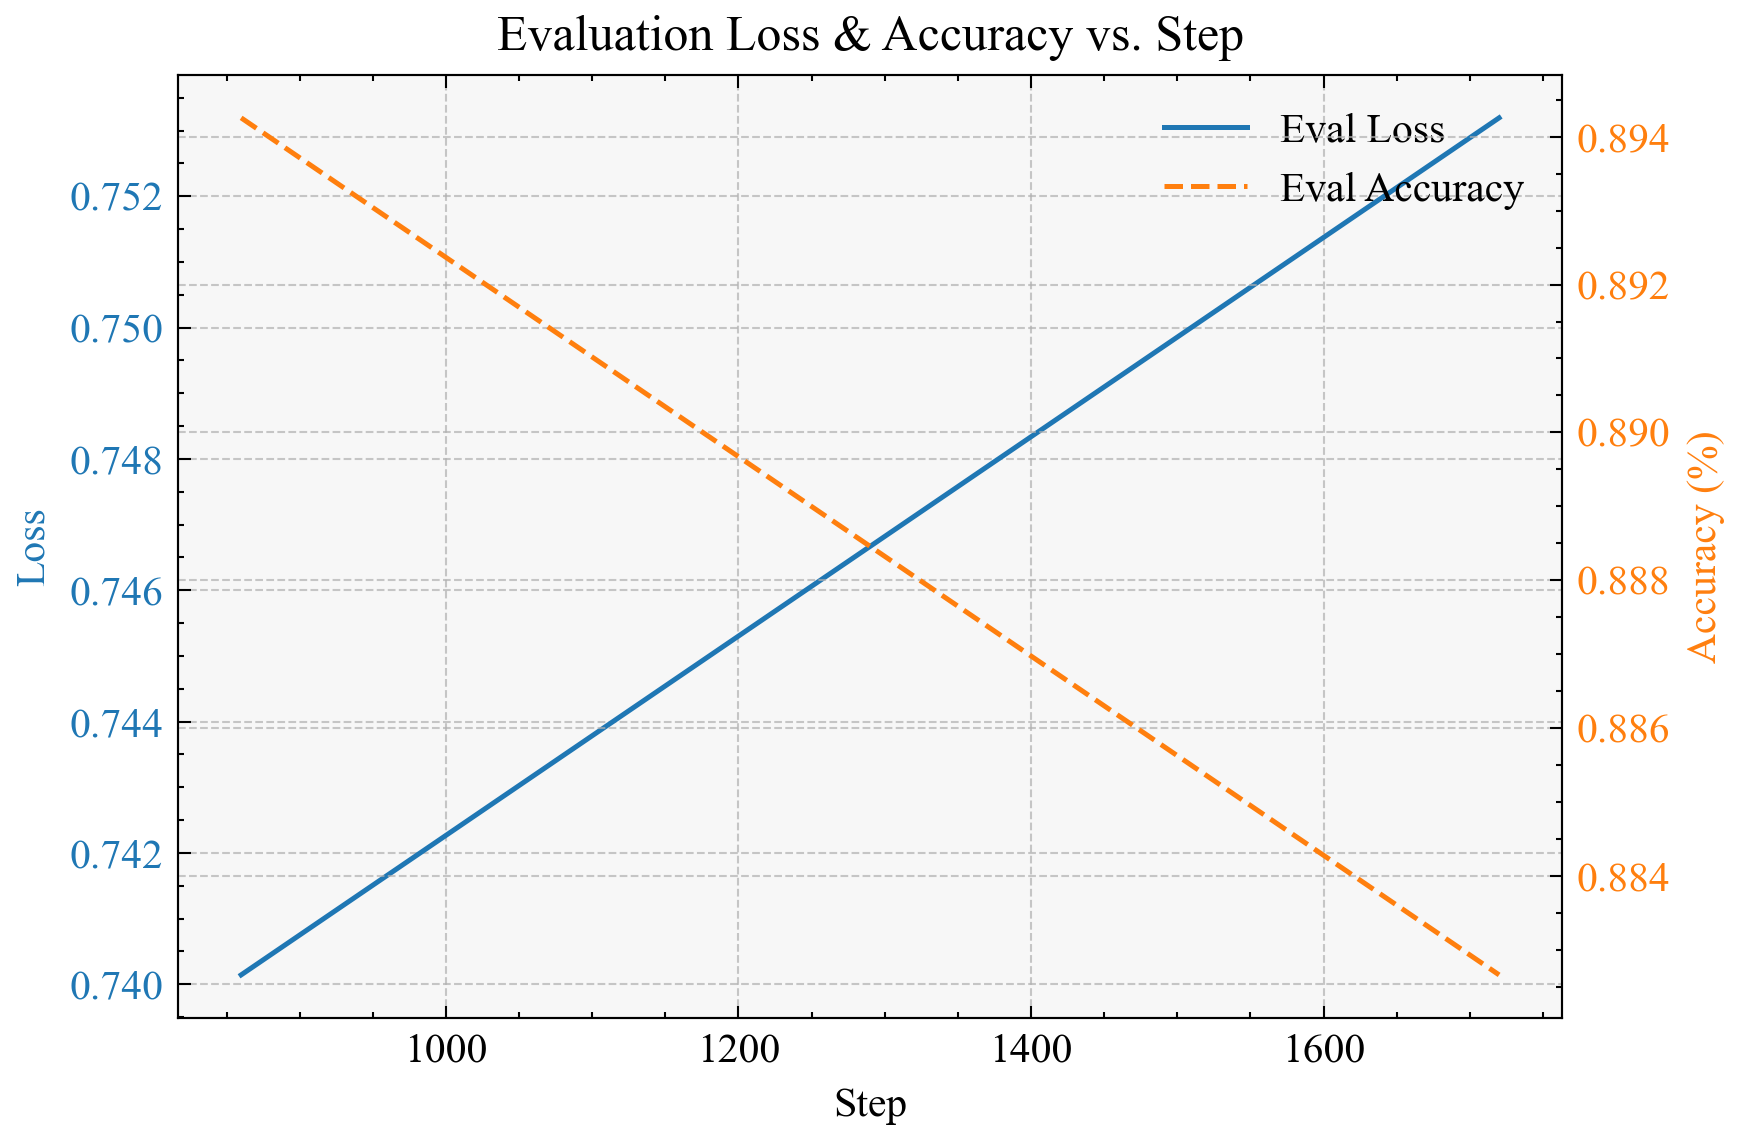

In [6]:
# ── CONFIG ──────────────────────────────────────────────────────────────────
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILES = [
    Path("wandb_export_2025-04-21T19_58_15.707-04_00.csv"),  # accuracy
    Path("wandb_export_2025-04-21T19_58_08.859-04_00.csv"),  # loss
]
STEP_MAX = 1720  # teacher‑model range

# Academic style (fallback – no LaTeX)
plt.rcParams.update({
    "font.family"   : "serif",
    "figure.dpi"    : 300,
    "axes.facecolor": "#f7f7f7",
    "axes.grid"     : True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha"    : 0.7,
    "text.usetex"   : False,          # keep matplotlib from invoking LaTeX
})

# ── HELPERS ────────────────────────────────────────────────────────────────
def detect_columns(df: pd.DataFrame):
    """
    Return (step_col, loss_col, acc_col)
    Either loss_col or acc_col may be None if not present.
    """
    cols_lower = [c.lower() for c in df.columns]

    # step
    step_candidates = [c for c, cl in zip(df.columns, cols_lower) if "step" in cl]
    step_col = step_candidates[0] if step_candidates else df.columns[0]

    # loss
    loss_candidates = [c for c, cl in zip(df.columns, cols_lower)
                       if "loss" in cl and not any(x in cl for x in ("min", "max", "epoch"))]
    loss_col = loss_candidates[0] if loss_candidates else None

    # accuracy
    acc_candidates = [c for c, cl in zip(df.columns, cols_lower)
                      if ("acc" in cl or "accuracy" in cl) and
                         not any(x in cl for x in ("min", "max", "epoch"))]
    acc_col = acc_candidates[0] if acc_candidates else None

    return step_col, loss_col, acc_col

def load_metrics(paths):
    """Return (loss_df, step_loss, loss_col) and (acc_df, step_acc, acc_col)."""
    loss_info = acc_info = None

    for p in paths:
        if not p.exists():
            raise FileNotFoundError(f"CSV not found: {p}")

        df = pd.read_csv(p)
        step_col, loss_col, acc_col = detect_columns(df)

        if loss_col and not acc_col:
            loss_info = (df, step_col, loss_col)
        elif acc_col and not loss_col:
            acc_info = (df, step_col, acc_col)
        else:  # both present – decide by the column names
            if loss_col and "loss" in loss_col.lower():
                loss_info = (df, step_col, loss_col)
            if acc_col and "acc" in acc_col.lower():
                acc_info = (df, step_col, acc_col)

    if loss_info is None or acc_info is None:
        raise RuntimeError("Could not uniquely identify one CSV with loss and one with accuracy.")

    return loss_info, acc_info

# ── MAIN ───────────────────────────────────────────────────────────────────
# 1.  Load & classify
(loss_df, step_loss, loss_col), (acc_df, step_acc, acc_col) = load_metrics(CSV_FILES)

# 2.  Trim to STEP_MAX and sort
loss_df = loss_df[loss_df[step_loss] <= STEP_MAX].sort_values(step_loss)
acc_df  = acc_df[acc_df[step_acc]  <= STEP_MAX].sort_values(step_acc)

# 3.  Plot
fig, ax_left = plt.subplots(figsize=(6, 4))
ax_right = ax_left.twinx()

ax_left.plot(
    loss_df[step_loss],
    loss_df[loss_col],
    label="Eval Loss",
    color="tab:blue",
    linewidth=1.2,
)
ax_left.set_xlabel("Step")
ax_left.set_ylabel("Loss", color="tab:blue")
ax_left.tick_params(axis="y", labelcolor="tab:blue")

ax_right.plot(
    acc_df[step_acc],
    acc_df[acc_col],
    label="Eval Accuracy",
    color="tab:orange",
    linestyle="--",
    linewidth=1.2,
)
ax_right.set_ylabel("Accuracy (%)", color="tab:orange")
ax_right.tick_params(axis="y", labelcolor="tab:orange")

plt.title(f"Evaluation Loss & Accuracy vs. Step")
# single legend
lines, labels = ax_left.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax_left.legend(lines + lines2, labels + labels2, loc="upper right")

fig.tight_layout()
plt.show()


## Plot the training loss for the student model

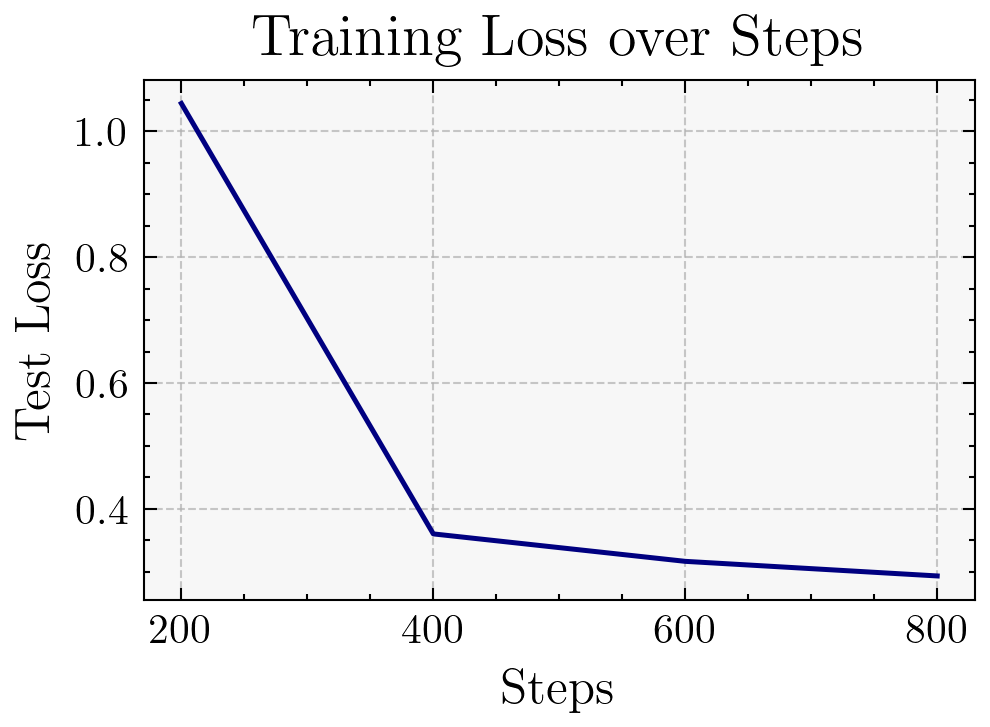

In [2]:
plt.style.use(['science', 'high-vis'])

# Enable LaTeX-style text rendering and Times New Roman font
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 300,                # Higher resolution
    "axes.facecolor": "#f7f7f7",      # Light grey facecolor for contrast
})

# Read the training loss CSV
csv_path = "wandb_export_2025-04-21T20_33_50.348-04_00.csv"
df = pd.read_csv(csv_path)

# Identify columns
step_col = next((c for c in df.columns if "global_step" in c.lower()), df.columns[0])
loss_col = next(
    (c for c in df.columns if "loss" in c.lower() and "min" not in c.lower() and "max" not in c.lower()),
    df.columns[1]
)

# Filter to first 1600 steps
df_filtered = df

fig, ax = plt.subplots()  # higher resolution
ax.plot(df_filtered[step_col], df_filtered[loss_col], linewidth=1.2, color='navy')

ax.set_title("Training Loss over Steps", fontsize=14)
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Test Loss", fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
fig.savefig('train_loss_plot_student.pdf', format='pdf', bbox_inches='tight')